# Single Subject GLM Analysis using the Localizer dataset

In this lab, extend your work from the previous lab to work with 3D brain data. The preprocessed data of the first subject in the localizer study is included.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import sin, pi, arange
from nltools.external import glover_hrf

%matplotlib inline
import matplotlib.pyplot as plt

import nibabel as nib

import scipy.misc
from scipy import ndimage
from ipywidgets import interact_manual, interact

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


Load the functional image of the first subject.

In [2]:
data = nib.load('preprocessed_fMRI_bold.nii.gz')

We should get a sequence of 128 frames of 3D images of the shape (53, 63, 46).

In [3]:
data.get_fdata().shape

(53, 63, 46, 128)

Let's plot a few brain slices just to check if we are actually seeing some brain.

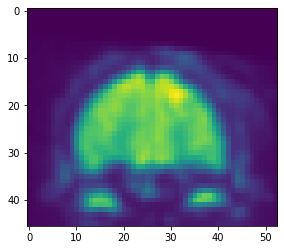

In [4]:
# Note: Shawn rotated it 90 degrees
plt.imshow(ndimage.rotate(data.get_fdata()[:,55,:,10], 90))

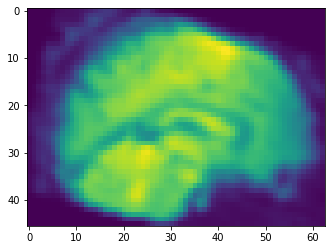

In [5]:
# Note: Shawn rotated it 90 degrees
plt.imshow(ndimage.rotate(data.get_fdata()[25,:,:,0], 90))

Let's load the mask data for this subject.

In [6]:
mask = nib.load('./sub-S01_mask.nii.gz')

The shape of the mask data should be identical to that of a signle frame in the brain data.

In [7]:
mask.get_fdata().shape

(53, 63, 46)

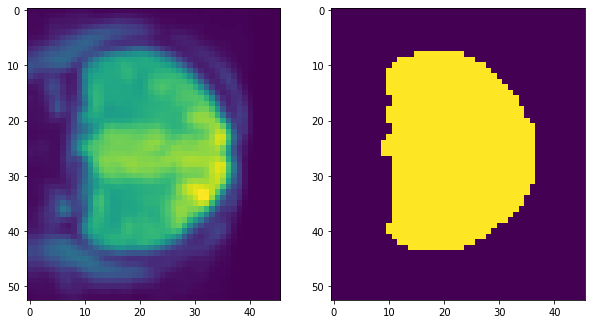

In [8]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[:,50,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[:,50,:])

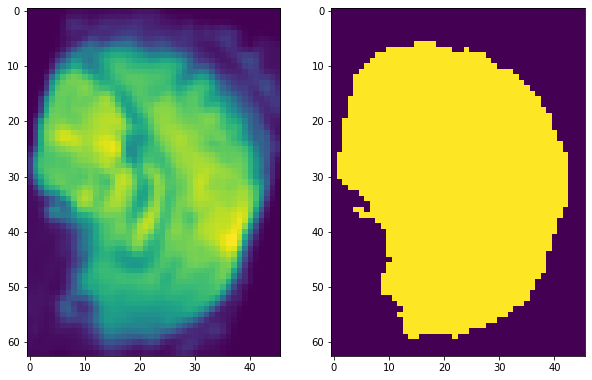

In [9]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[25,:,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[25,:,:])

# Exercise 

For each of the question below, use your code to perform the analysis.

## Which regions are more involved with visual compared to auditory sensory processing?

First, we need the localizer study data:

In [10]:
# (seconds)
total_scan_time = 300 # five minutes

# (milliseconds)
onset_times = [0,2400,5700,8700,11400,15000,18000,20700,23700,26700,29700,33000,35400,39000,41700,44700,48000,
        50700,53700,56400,59700,62400,66000,69000,71400,75000,78000,80400,83400,87000,89700,93000,96000,
        99000,102000,105000,108000,110400,113700,116700,119400,122700,125400,129000,131400,135000,137700,
        140400,143400,146700,149400,153000,156000,159000,162000,164400,167700,170400,173700,176700,179700,
        182700,186000,188400,191700,195000,198000,201000,203700,207000,210000,212700,215700,218700,221400,
        224700,227700,230700,234000,236700,240000,243000,246000,248400,251700,254700,257400,260400,264000,
        266700,269700,272700,275400,278400,281700,284400,288000,291000,293400,296700]

# onset type (one-based index)
onset_types = [8,8,11,1,3,10,5,10,4,6,10,2,7,9,9,7,7,11,11,9,
        1,4,11,5,6,9,11,11,7,3,10,11,2,11,11,11,7,11,11,6,
        10,2,8,11,9,7,7,2,3,10,1,8,2,9,3,8,9,4,7,1,
        11,11,11,1,7,9,8,8,2,2,2,6,6,1,8,1,5,3,8,10,
        11,11,9,1,7,4,4,8,2,1,1,11,5,2,11,10,9,5,10,10]

localizer_labels = ['horizontal_checkerboard',
          'vertical_checkerboard',
          'motor_right_auditory',          
          'motor_left_auditory',
          'motor_right_visual',          
          'motor_left_visual',
          'subtraction_auditory',
          'subtraction_visual',          
          'sentence_visual',   
          'sentence_auditory']

def get_localizer_design_data():

    # onset type
    onset_types_0_based = np.array(onset_types) - 1
    
    events = list(zip(onset_times, onset_types_0_based))
    
    # ignore the last onset type
    events = [(onset_time, onset_type) for (onset_time, onset_type) in events if onset_type != 10]
    
    return (events, localizer_labels)

events, labels = get_localizer_design_data()

Next, let's dump all our functions from the last lab:

In [93]:
# ## Returns a univariate time series that is a design vector for one event type
# def compute_design_vector(events, event_index, num_time_slices=128, tr=2.4):
#     selected_onset_times = [onset_time for onset_time, onset_type in events if onset_type == event_index]
#     iss = np.floor(np.array(selected_onset_times) / (tr * 1000)).astype(int)                 
#     line = np.zeros(num_time_slices)
#     line[iss] = 1
#     return line

# #----DesignMatrixUtils------------------------------------------------------------------------------------
# class DesignMatrixUtils:
#     pass

# ## Returns a design matrix: a pandas dataframe where each column is an event design vector
# def create_design_matrix(events, labels, tr=2.4, duration=128): 
#     df = pd.DataFrame(columns=labels)
#     for i in range(len(labels)):
#         line = compute_design_vector(events, i, duration, tr).astype('int')
#         df[labels[i]] = line
#     return df

# DesignMatrixUtils.create_design_matrix = create_design_matrix

# ## Plots a design matrix. Each column (or row, depending on orientation) is a design vector
# def plot(design_matrix, orientation = 'horizontal'):  
#     values = design_matrix.values 
#     labels = design_matrix.columns
#     m = len(labels)
#     if orientation == 'vertical':
#         f, a = plt.subplots(ncols=m, figsize=(m*1.5, 10), sharey=True)
#     elif orientation == 'horizontal':
#         f, a = plt.subplots(nrows=m, figsize=(10, m), sharex=True)
#     else:
#         raise Exception("Invalid orientation") 
#     times = range(values.shape[0])
#     for i in range(0, m):        
#         label = labels[i]
        
#         if orientation == 'vertical':
#             a[i].plot(values[:,i], times)
#             a[i].set_title(label, fontsize=12, rotation=45)
#         else:
#             a[i].plot(times,values[:,i])
#             a[i].set_title(label, fontsize=12)
#     if orientation == 'vertical':
#         plt.gca().invert_yaxis()
#     plt.tight_layout()
#     return

# DesignMatrixUtils.plot = plot

# ## Returns a subset of a design matrix containing only events with "[task]" in their name
# def select_tasks_with_name(design_matrix, task):
#     selected_tasks = [col for col in design_matrix.columns if task in col]
#     return design_matrix[selected_tasks]

# DesignMatrixUtils.select_tasks_with_name = select_tasks_with_name

# ## Plots a design matrix using a heatmap
# def heatmap(design_matrix):     
#     sns.heatmap(design_matrix)
#     return

# DesignMatrixUtils.heatmap = heatmap

# ## Adds an intercept column to a design matrix
# def add_intercept(design_matrix):  
#     design_matrix_copy = design_matrix.copy()
#     n_rows, n_cols = design_matrix.shape
#     design_matrix_copy['intercept'] = np.ones(n_rows)
#     return design_matrix_copy

# DesignMatrixUtils.add_intercept = add_intercept

# ## Adds polynomial columns to a design matrix
# def add_poly(design_matrix, degrees=2, flipped=False):
#     frames = design_matrix.shape[0]
#     time = np.linspace(-1, 1, frames)
#     for i in range(degrees+1):
#         key = '1-poly%d'%(i) if flipped else 'poly%d'%(i)
#         design_matrix[key] = (time ** i) * (-1 if flipped else 1)
#     return design_matrix

# DesignMatrixUtils.add_poly = add_poly

# ## Adds a cosine column to a design matrix
# def add_cosine(design_matrix, freq, amplitude, phase = 0):     
#     duration = design_matrix.shape[0]
#     time = np.linspace(0, 1, duration)
#     w = amplitude * sin(2*pi*freq*time + pi*phase)
#     copy = design_matrix.copy()
#     copy['cos'+str(freq)] = w
#     return copy
#     ### END SOLUTION
# DesignMatrixUtils.add_cosine = add_cosine

# ## Convolves each column in a design matrix with the hrf function
# def convolve_hrf(design_matrix, tr=2.4):     
#     design_matrix_copy = design_matrix.copy() # Avoid modifying the original dataframe
#     hrf = glover_hrf(tr, oversampling=1) 
#     labels = design_matrix.columns
#     for label in labels:
#         design_matrix_copy[label] = np.convolve(design_matrix_copy[label].to_numpy(), hrf, mode='same') 
#     return design_matrix_copy

# DesignMatrixUtils.convolve_hrf = convolve_hrf

# ## Returns a design matrix with all functions in [funcs] applied to it
# def add_many(design_matrix, funcs = []):     
#     design_matrix_copy = design_matrix.copy() # Avoid modifying the original dataframe
#     for func in funcs:
#         design_matrix_copy = func(design_matrix_copy)
#     return design_matrix_copy
    
# DesignMatrixUtils.add_many = add_many


# #----1D GLM------------------------------------------------------------------------------------
# ## Plots toy 1D brain data as a series of 1D images (through time, going down)
# def plot_functional_data_1d(data):
#     plt.figure(figsize=(40,4))
#     n_tr = data.shape[2]
#     c = int(n_tr/2)
#     times = [0,1,2,3,4,5] + [c,c+1,c+2,c+3,c+4,c+5]
#     m = len(times)
#     for i, time in enumerate(times):
#         axes = plt.subplot(m,1,i+1)
#         plt.imshow(data[:,:,time], vmin=-1, vmax=1, cmap='bwr')
#         plt.ylabel(str(time), fontsize=20, rotation=0, labelpad=50, va='center')
#         axes.get_yaxis().set_ticks([])
        
# ## Given a design matrix and a one-hot vector of betas 
# ## (of length equal to number of labels (columns) in the design matrix), 
# ## returns a univariate time series showing each time a beta value spikes (spikes equal value in corresponding d_s column * corresponding beta)
# def generate_time_series(design_matrix, betas):
#     y = np.zeros(design_matrix.shape[0])    
#     for col, beta in zip(design_matrix.columns, betas):
#         y = y + design_matrix[col] * beta
#     return y

# ## We compute GLM regression using this function
# def estimate_beta(X, Y):
#     return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)

# ## Compute a beta map for a toy example of 1D images
# def compute_beta_map(data, X):
#     size = data.shape[1]
#     n_regressors = X.shape[1]
#     beta_map = np.zeros((1,size,n_regressors))    
#     for i in range(size):
#         Y = data[0,i,:]
#         bs = estimate_beta(X, Y)
#         beta_map[0,i,:] = bs
#     return beta_map

# ## Plot a beta map for a 1D toy example 
# def plot_beta_map_1d(beta_map, design_matrix):
#     plt.figure(figsize=(40,4))
#     labels = design_matrix.columns
#     m = len(labels)    
#     for i, label in enumerate(labels):
#         axes = plt.subplot(m,1,i+1)
#         plt.imshow(beta_map[:,:,i], cmap='bwr', vmin=-1, vmax=1)
#         plt.ylabel(label, fontsize=12, rotation=0, labelpad=40, va='center')
#         axes.get_yaxis().set_ticks([])
        
# ## Given a beta map and a vector of contrasts
# ## (of the length of the number of betas,
# ## assigning positive values to events in one group and negative values to events in another group),
# ## returns a contrast map
# def compute_contrast(beta_map, contrast):       
#     b = np.squeeze(beta_map)   
#     c = np.array(contrast).T
#     cs = np.dot(b,c).T 
#     # expand cs to a 2D-array so that we can show it using imshow
#     cs = np.expand_dims(cs, axis=0)
#     return cs

# ## Computes a contrast map then plots it
# def show_contrast(beta_map, contrast):
#     cs = compute_contrast(beta_map, contrast)
#     plt.figure(figsize=(40,2))
#     plt.imshow(cs, cmap='gray')

# #----2D GLM------------------------------------------------------------------------------------
# from scipy.ndimage.filters import gaussian_filter

# class FunctionalDataSim2D:
#     @staticmethod
#     def create(height, weight, n_tr):
#         data = np.zeros((height, weight, n_tr))
#         return data
    
#     @staticmethod
#     def plot_data(data, selected = None):
#         times = selected
#         m = len(times)
#         plt.figure(figsize=(8*m,4))
        
#         for i, time in enumerate(times):
#             axes = plt.subplot(m,1,i+1)
#             plt.imshow(data[:,:,time], vmin=-1, vmax=1, cmap='bwr')
#             plt.ylabel(str(time), fontsize=20, rotation=0, labelpad=50, va='center')
#             axes.get_yaxis().set_ticks([])
#         return
    
#     @staticmethod
#     # mutate 'data' by adding time series calculated from 'design_matrix' and 'betas' at given 'locations'
#     def add(data, design_matrix, betas, locations):
#         for i in range(len(locations)):
#             time_series = generate_time_series(design_matrix, betas)
#             data[locations[i][0],locations[i][1],:] = time_series
#         return
    
#     @staticmethod
#     def plot_beta_map(beta_map, design_matrix):
#         betas = beta_map.shape[2]
#         plt.figure(figsize=(8*betas,8))
        
#         for i, beta in enumerate(range(betas)):
#             axes = plt.subplot(betas,1,i+1)
#             plt.imshow(beta_map[:,:,beta], vmin=-1, vmax=1, cmap='bwr')
#             plt.ylabel(design_matrix.columns[i], fontsize=10, rotation=0, labelpad=50, va='center')
#             axes.get_yaxis().set_ticks([])
#         return
    
#     def compute_beta_map(data, X):
#         n_regressors = X.shape[1]
#         beta_map = np.zeros((data.shape[0],data.shape[1],data.shape[2],n_regressors)) 
        
#         for i in range(data.shape[0]):
#             for j in range(data.shape[1]):
#                 for k in range (data.shape[2]):
#                     Y = data.get_fdata()#data[i,j,:]
#                     bs = estimate_beta(X, Y)
#                     beta_map[i,j,:] = bs
#         return beta_map
    
#     @staticmethod
#     def show_contrast(beta_map, contrast):
#         cs = compute_contrast(beta_map, contrast).squeeze().T
#         plt.figure(figsize=(40,2))
#         plt.imshow(cs.squeeze(), cmap='gray')
        
#     @staticmethod
#     def show_contrast_with_threshold(beta_map, contrast, threshold):
#         cs = compute_contrast(beta_map, contrast).squeeze().T
#         maximum = cs.max()
#         cs[cs < maximum*threshold] = 0
# #         cs[cs >=maximum*threshold] = 1
#         cs[mask] = 0 # Everywhere that mask is 1, cs will be set to 0
#         plt.figure(figsize=(40,2))
#         plt.imshow(cs.squeeze(), cmap='gray')
#         return cs
    
#     @staticmethod
#     def smooth(data):
#         for i in range(data.shape[2]):
#             data[:,:,i] = gaussian_filter(data[:,:,i],sigma=[1,1])
#         return





### Next let's start code for 3D GLM:

In [94]:
# from scipy.ndimage.filters import gaussian_filter
# from mpl_toolkits import mplot3d
# import scipy.misc
# from scipy import ndimage

# class FunctionalData3D:
    
#     @staticmethod
#     def plot_data(data, selected = None, axis='x', pos=0):
#         times = selected
#         m = len(times)
#         plt.figure(figsize=(10*m,20))
        
#         for i, time in enumerate(times):            
#             if (axis=='x' or axis=='X'):
#                 axes = plt.subplot(m,1,i+1, xlabel='Y', ylabel='Z')
#                 imgX = data.get_fdata()[pos,:,:,time]
#                 plt.imshow(ndimage.rotate(imgX, 90))
#             if (axis=='y' or axis=='Y'):
#                 axes = plt.subplot(m,1,i+1, xlabel='X', ylabel='Z')
#                 imgY = data.get_fdata()[:,pos,:,time]
#                 plt.imshow(ndimage.rotate(imgY, 90))
#             if (axis=='z' or axis=='Z'):
#                 axes = plt.subplot(m,1,i+1, xlabel='X', ylabel='Y')
#                 imgZ = data.get_fdata()[:,:,pos,time]
#                 plt.imshow(ndimage.rotate(imgZ, 90))
            
#             plt.ylabel(str(time), fontsize=20, rotation=0, labelpad=50, va='center')
#             axes.get_yaxis().set_ticks([])
#         return
    
#     @staticmethod
#     # mutate 'data' by adding time series calculated from 'design_matrix' and 'betas' at given 'locations'
#     def add(data, design_matrix, betas, locations):
#         for i in range(len(locations)):
#             time_series = generate_time_series(design_matrix, betas)
#             data[locations[i][0],locations[i][1],:] = time_series
#         return
    
#     @staticmethod
#     def plot_beta_map(beta_map, design_matrix): # TODO: rewrite for 3D
#         betas = beta_map.shape[2]
#         plt.figure(figsize=(8*betas,8))
        
#         for i, beta in enumerate(range(betas)):
#             axes = plt.subplot(betas,1,i+1)
#             plt.imshow(beta_map[:,:,beta], vmin=-1, vmax=1, cmap='bwr')
#             plt.ylabel(design_matrix.columns[i], fontsize=10, rotation=0, labelpad=50, va='center')
#             axes.get_yaxis().set_ticks([])
#         return
    
#     def compute_beta_map(data, X): # TODO: rewrite for 3D
#         n_regressors = X.shape[1]
#         beta_map = np.zeros((data.shape[0],data.shape[1],data.shape[2],n_regressors)) 
        
#         for i in range(data.shape[0]):
#             for j in range(data.shape[1]):
#                 for k in range (data.shape[2]):
#                     Y = data.get_fdata()[i,j,k,:]#data[i,j,:]
#                     bs = estimate_beta(X, Y)
#                     beta_map[i,j,k,:] = bs
#         return beta_map
    
#     @staticmethod
#     def show_contrast(beta_map, contrast, axis='x', pos=0): # TODO: rewrite for 3D
#         cs = compute_contrast(beta_map, contrast).squeeze().T
#         #cs[mask] = 0
#         plt.figure(figsize=(40,2))
        
#         if (axis=='x' or axis=='X'):
#             imgX = cs[pos,:,:].squeeze()
#             plt.imshow(ndimage.rotate(imgX, 90), cmap='gray')
#             #plt.imshow(ndimage.rotate(mask.get_fdata()[pos,:,:], 90), alpha=0.5)
#         if (axis=='y' or axis=='Y'):
#             imgY = cs[:,pos,:].squeeze()
#             plt.imshow(ndimage.rotate(imgY, 90), cmap='gray')
#         if (axis=='z' or axis=='Z'):
#             imgZ = cs[:,:,pos].squeeze()
#             plt.imshow(ndimage.rotate(imgZ, 90), cmap='gray')
#         #plt.imshow(cs[:,2,:].squeeze(), cmap='gray')
        
#     @staticmethod
#     def show_contrast_with_threshold(beta_map, contrast, axis='x', pos=0, threshold=0.5):
#         cs = compute_contrast(beta_map, contrast).squeeze().T
#         maximum = cs.max()
#         cs[cs < maximum*threshold] = 0
#         plt.figure(figsize=(40,2))
        
#         if (axis=='x' or axis=='X'):
#             imgX = cs[pos,:,:].squeeze()
#             plt.imshow(ndimage.rotate(imgX, 90), cmap='gray')
#         if (axis=='y' or axis=='Y'):
#             imgY = cs[:,pos,:].squeeze()
#             plt.imshow(ndimage.rotate(imgY, 90), cmap='gray')
#         if (axis=='z' or axis=='Z'):
#             imgZ = cs[:,:,pos].squeeze()
#             plt.imshow(ndimage.rotate(imgZ, 90), cmap='gray')
        
#         return cs
    
#     @staticmethod
#     def smooth(data):
#         for i in range(data.shape[2]):
#             data[:,:,i] = gaussian_filter(data[:,:,i],sigma=[1,1])
#         return



Let's use some of these functions to get started:

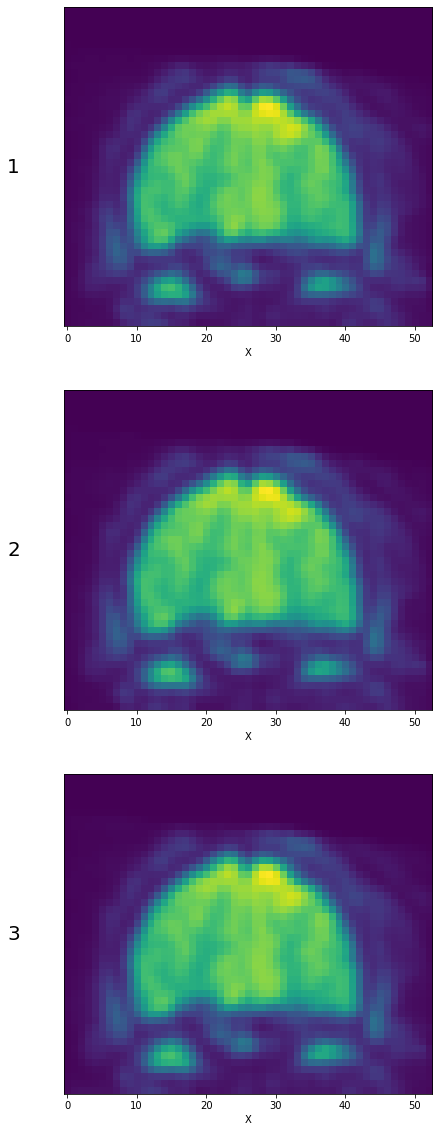

In [13]:
FunctionalData3D.plot_data(data, [1,2,3], axis='Y', pos=54)

### Create a design matrix for the localizer data

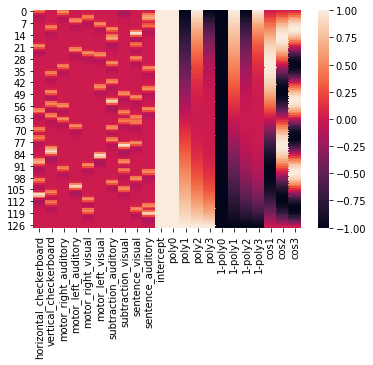

In [14]:
design_matrix_localizer = DesignMatrixUtils.create_design_matrix(events, labels)

motor_design_matrix = select_tasks_with_name(design_matrix_localizer, 'motor')

#DesignMatrixUtils.plot(motor_design_matrix, orientation='vertical')
#DesignMatrixUtils.heatmap(motor_design_matrix)
#DesignMatrixUtils.plot(convolve_hrf(design_matrix_localizer), orientation='vertical')

#design_matrix_localizer_hrf = DesignMatrixUtils.convolve_hrf(design_matrix_localizer, 2.4)
#DesignMatrixUtils.heatmap(design_matrix_localizer_hrf)

funcs = [
    lambda dm : DesignMatrixUtils.convolve_hrf(dm, 2),
    lambda dm : DesignMatrixUtils.add_intercept(dm),
    lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 2),
    lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 3),
    lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 2, flipped = True),
    lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 3, flipped = True),  
    lambda dm : DesignMatrixUtils.add_cosine(dm, 1, 1),
    lambda dm : DesignMatrixUtils.add_cosine(dm, 2, 1),    
    lambda dm : DesignMatrixUtils.add_cosine(dm, 3, 1),        
]

design_matrix_localizer_full = DesignMatrixUtils.add_many(design_matrix_localizer, funcs)
DesignMatrixUtils.heatmap(design_matrix_localizer_full)

# design_matrix_motor_full = DesignMatrixUtils.add_many(motor_design_matrix, funcs)
# DesignMatrixUtils.heatmap(design_matrix_motor_full)


## So, back to the question, which regions are more involved with visual compared to auditory sensory processing?

In [15]:
# This takes a while to calculate
beta_map_visual_vs_aud = FunctionalData3D.compute_beta_map(data, design_matrix_localizer_full.values)


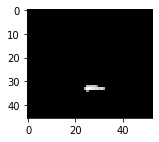

In [16]:
#FunctionalData3D.plot_beta_map(beta_map_visual_vs_aud, design_matrix_localizer_full)
# FunctionalData3D.show_contrast(beta_map_visual_vs_aud, [1,1,-1,-1,1,1,-1,1,1,-1,0,0,0,0,0,0,0,0,0,0,0,0], axis='y', pos=50)
z = FunctionalData3D.show_contrast_with_threshold(beta_map_visual_vs_aud, [1,1,-1,-1,1,1,-1,1,1,-1,0,0,0,0,0,0,0,0,0,0,0,0], axis='y', pos=10, threshold=.1)


## Which regions are more involved in processing numbers compared to words?

In [17]:
# This takes a while to calculate
beta_map_nums_vs_words = FunctionalData3D.compute_beta_map(data, design_matrix_localizer_full.values)


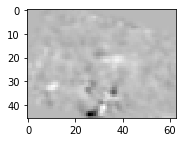

In [18]:
#FunctionalData3D.plot_beta_map(beta_map_nums_vs_words, design_matrix_localizer_full)
z = FunctionalData3D.show_contrast(beta_map_nums_vs_words, [0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0], axis='x', pos=30) # Assumes "subtraction_visual" is the only number task, "sentence_visual/auditory" are only word tasks


## Which regions are more involved with motor compared to cognitive processes (e.g., language and math)?

In [19]:
# This takes a while to calculate
beta_map_motor_vs_cog = FunctionalData3D.compute_beta_map(data, design_matrix_localizer_full.values)


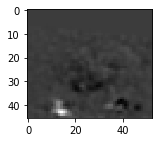

In [20]:
#FunctionalData3D.plot_beta_map(beta_map_motor_vs_cog, design_matrix_localizer_full)
z = FunctionalData3D.show_contrast(beta_map_motor_vs_cog, [0,0,1,1,1,1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0], axis='y', pos=60)


## Extend the lab with requested features
 - Sliders to explore slices (/)
     - Default slider value on most active slice (/)
     
     
 - Generate contrast vector from string input (/)
 
 
 - Select voxel and show crosshairs in all 3 axes (NOT INTERACTIVELY) (/)
 
 
 - Return coordinates of top cluster for each contrast
     - ndimage clustering method
 

### Generate contrast vector from string input

In [21]:
def contrast_vector_from_name(design_matrix, pos_name, neg_name):
    contrast_vector = np.zeros(design_matrix.shape[1])
    cols = design_matrix.columns
    
    for i,col in enumerate(cols):
        if (pos_name in col):
            contrast_vector[i] = 1
        elif (neg_name in col):
            contrast_vector[i] = -1
            
    # Hardcodings
    if (pos_name == "visual"):
        contrast_vector[0] = 1 # horizontal checkerboard
        contrast_vector[1] = 1 # vertical checkerboard
    if (neg_name == "visual"):
        contrast_vector[0] = -1 # horizontal checkerboard
        contrast_vector[1] = -1 # vertical checkerboard
    if ("number" in pos_name):
        contrast_vector[6] = 1 # subtraction_auditory 
        contrast_vector[7] = 1 # subtraction_visual
    if ("number" in neg_name):
        contrast_vector[6] = -1 # subtraction_auditory 
        contrast_vector[7] = -1 # subtraction_visual
    if ("word" in pos_name):
        contrast_vector[8] = 1 # sentence_visual
        contrast_vector[9] = 1 # sentence_auditory
    if ("word" in neg_name):
        contrast_vector[8] = -1 # sentence_visual
        contrast_vector[9] = -1 # sentence_auditory
    if ("cog" in pos_name):
        contrast_vector[6] = 1 # subtraction_auditory 
        contrast_vector[7] = 1 # subtraction_visual
        contrast_vector[8] = 1 # sentence_visual
        contrast_vector[9] = 1 # sentence_auditory
    if ("cog" in neg_name):
        contrast_vector[6] = -1 # subtraction_auditory 
        contrast_vector[7] = -1 # subtraction_visual
        contrast_vector[8] = -1 # sentence_visual
        contrast_vector[9] = -1 # sentence_auditory
        
    # make the numbers add up to 0
    # count number of positives and negs, divide 1 by those numbers
    num_positives = 0
    num_negatives = 0
    
    for i,num in enumerate(contrast_vector):
        if (num == 1):
            num_positives = num_positives + 1
        elif (num == -1):
            num_negatives = num_negatives + 1
            
    pos_value = float(1.0/num_positives)
    neg_value = float(1.0/num_negatives)
    
    for i,num in enumerate(contrast_vector):
        if (num == 1):
            contrast_vector[i] = pos_value
        elif (num == -1):
            contrast_vector[i] = neg_value
    
    return contrast_vector
    
    
cs = contrast_vector_from_name(design_matrix_localizer_full, "visual", "aud")
print(cs)

[0.16666667 0.16666667 0.25       0.25       0.16666667 0.16666667
 0.25       0.16666667 0.16666667 0.25       0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


### Select voxel and show crosshairs in all 3 axes (NOT INTERACTIVELY)

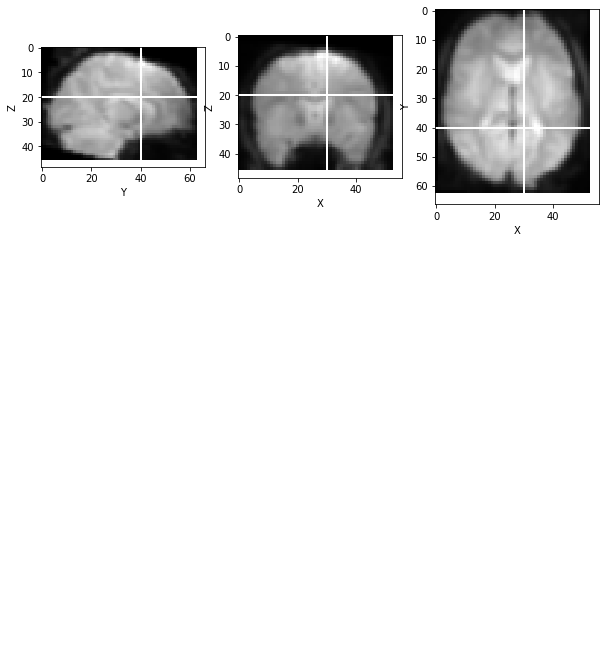

In [22]:
def show_voxel_with_crosshairs(data, x, y, z, t, beta = False):
    # if beta is True, search for interesting regions (max)
    if beta:
        shape = data.shape
    else:
        shape = data.get_fdata().shape
    xLength = shape[0]
    yLength = shape[1]
    zLength = shape[2]
    
    xIndex = x
    yIndex = y
    zIndex = z
    timeSlice = t
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,3,1, xlabel='Y', ylabel='Z')  
    if beta:
        imgX = data[xIndex,:,:,timeSlice]
    else:
        imgX = data.get_fdata()[xIndex,:,:,timeSlice]
    rotated_imgX = ndimage.rotate(imgX, 90)
    plt.imshow(rotated_imgX, 'gray', interpolation='none')
    plt.plot([0,yLength],[zIndex,zIndex],'w-', linestyle = "-", lw=2)
    plt.plot([yIndex,yIndex],[0,zLength],'w-', linestyle = "-", lw=2)
    plt.text(10, 245, 'x={}'.format(x), fontsize=12, color='white')
    
    plt.subplot(1,3,2, xlabel='X', ylabel='Z')
    if beta:
        imgY = data[:,yIndex,:,timeSlice]
    else:
        imgY = data.get_fdata()[:,yIndex,:,timeSlice]
    rotated_imgY = ndimage.rotate(imgY, 90)
    plt.imshow(rotated_imgY, 'gray', interpolation='none')
    plt.plot([0,xLength],[zIndex,zIndex],'w-', linestyle = "-", lw=2)
    plt.plot([xIndex,xIndex],[0,zLength],'w-', linestyle = "-", lw=2)
    plt.text(10, 175, 'y={}'.format(y), fontsize=12, color='white')
    
    plt.subplot(1,3,3, xlabel='X', ylabel='Y')
    if beta:
        imgZ = data[:,:,zIndex,timeSlice]
    else:
        imgZ = data.get_fdata()[:,:,zIndex,timeSlice]
    rotated_imgZ = ndimage.rotate(imgZ, 90)
    plt.imshow(rotated_imgZ, 'gray', interpolation='none')
    plt.plot([0,xLength],[yIndex,yIndex],'w-', linestyle = "-", lw=2)
    plt.plot([xIndex,xIndex],[0,yLength],'w-', linestyle = "-", lw=2)
    plt.text(10, 175, 'z={}'.format(z), fontsize=12, color='white')
    
    plt.show()
    
show_voxel_with_crosshairs(data, 30, 40, 20, 5)

### Sliders to explore slices

In [23]:
@interact(x=(0,52), y=(0,62), z=(0,45), t=(0,127))
def interact_with_voxels(x=1, y=1, z=1, t=1):
    show_voxel_with_crosshairs(data, x, y, z, t, beta=False)

interactive(children=(IntSlider(value=1, description='x', max=52), IntSlider(value=1, description='y', max=62)…

### Default slider value on most active slice

In [24]:
def sum_image_values(img):
    assert(len(img.shape)==2)
    return np.sum(img)

## Find maximum slices in beta map. Remember shape is: (53, 63, 46, 22)
def find_most_active_regions(beta_map):
    xLength = beta_map.shape[0]
    yLength = beta_map.shape[1]
    zLength = beta_map.shape[2]
    tLength = beta_map.shape[3]
    
    # Find max X image
    maxX = float("-inf")
    xVal = -1
    tXVal = -1
    for x in range(xLength):
        for t in range(tLength):
            betaImg = beta_map[x,:,:,t]
            imgSum = sum_image_values(betaImg)
            if (imgSum > maxX):
                maxX = imgSum
                xVal = x
                tXVal = t
                
    # Find max Y image
    maxY = float("-inf")
    yVal = -1
    tYVal = -1
    for y in range(yLength):
        for t in range(tLength):
            betaImg = beta_map[:,y,:,t]
            imgSum = sum_image_values(betaImg)
            if (imgSum > maxY):
                maxY = imgSum
                yVal = y
                tYVal = t
    
    # Find max Z image
    maxZ = float("-inf")
    zVal = -1
    tZVal = -1
    for z in range(zLength):
        for t in range(tLength):
            betaImg = beta_map[:,:,z,t]
            imgSum = sum_image_values(betaImg)
            if (imgSum > maxZ):
                maxZ = imgSum
                zVal = z
                tZVal = t
                
    # Use t that maximizes the sum of all three axis slices
    maxT = float("-inf")
    tVal = -1
    for t in [tXVal, tYVal, tZVal]:
        xSum = sum_image_values(beta_map[xVal,:,:,t])
        ySum = sum_image_values(beta_map[:,yVal,:,t])
        zSum = sum_image_values(beta_map[:,:,zVal,t])
        tSum = xSum + ySum + zSum
        if (tSum > maxT):
            tVal = t
            
    print(beta_map.shape)
    
    return xVal,yVal,zVal,tVal
    
x,y,z,t = find_most_active_regions(beta_map_motor_vs_cog)
# print(x)
# print(y)
# print(z)
# print(t)

(53, 63, 46, 22)


In [25]:
xStart,yStart,zStart,tStart = find_most_active_regions(beta_map_motor_vs_cog)

@interact(x=(0,52), y=(0,62), z=(0,45), t=(0,21))
def interact_with_voxels(x=xStart, y=yStart, z=zStart, t=tStart):
    show_voxel_with_crosshairs(beta_map_motor_vs_cog, x, y, z, t, True)

(53, 63, 46, 22)


interactive(children=(IntSlider(value=28, description='x', max=52), IntSlider(value=24, description='y', max=6…

### ndimage clustering method

num_labels: 21
calculated num labels: 22


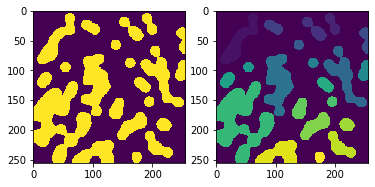

In [26]:
# image = beta_map_motor_vs_cog[:,24,:,5]
# plt.figure(figsize=(5,5))
# # plt.imshow(image)
n = 10
l = 256
im = np.zeros((l, l))
points = l*np.random.random((2, n**2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))
mask = im > im.mean()


labeled_img, num_labels = ndimage.label(mask)

#print(labeled_img[200])
print("num_labels: " + str(num_labels))
print("calculated num labels: " + str(len(np.unique(labeled_img))))

plt.subplot(1,2,1)
plt.imshow(mask)  
plt.subplot(1,2,2)  
plt.imshow(labeled_img)        

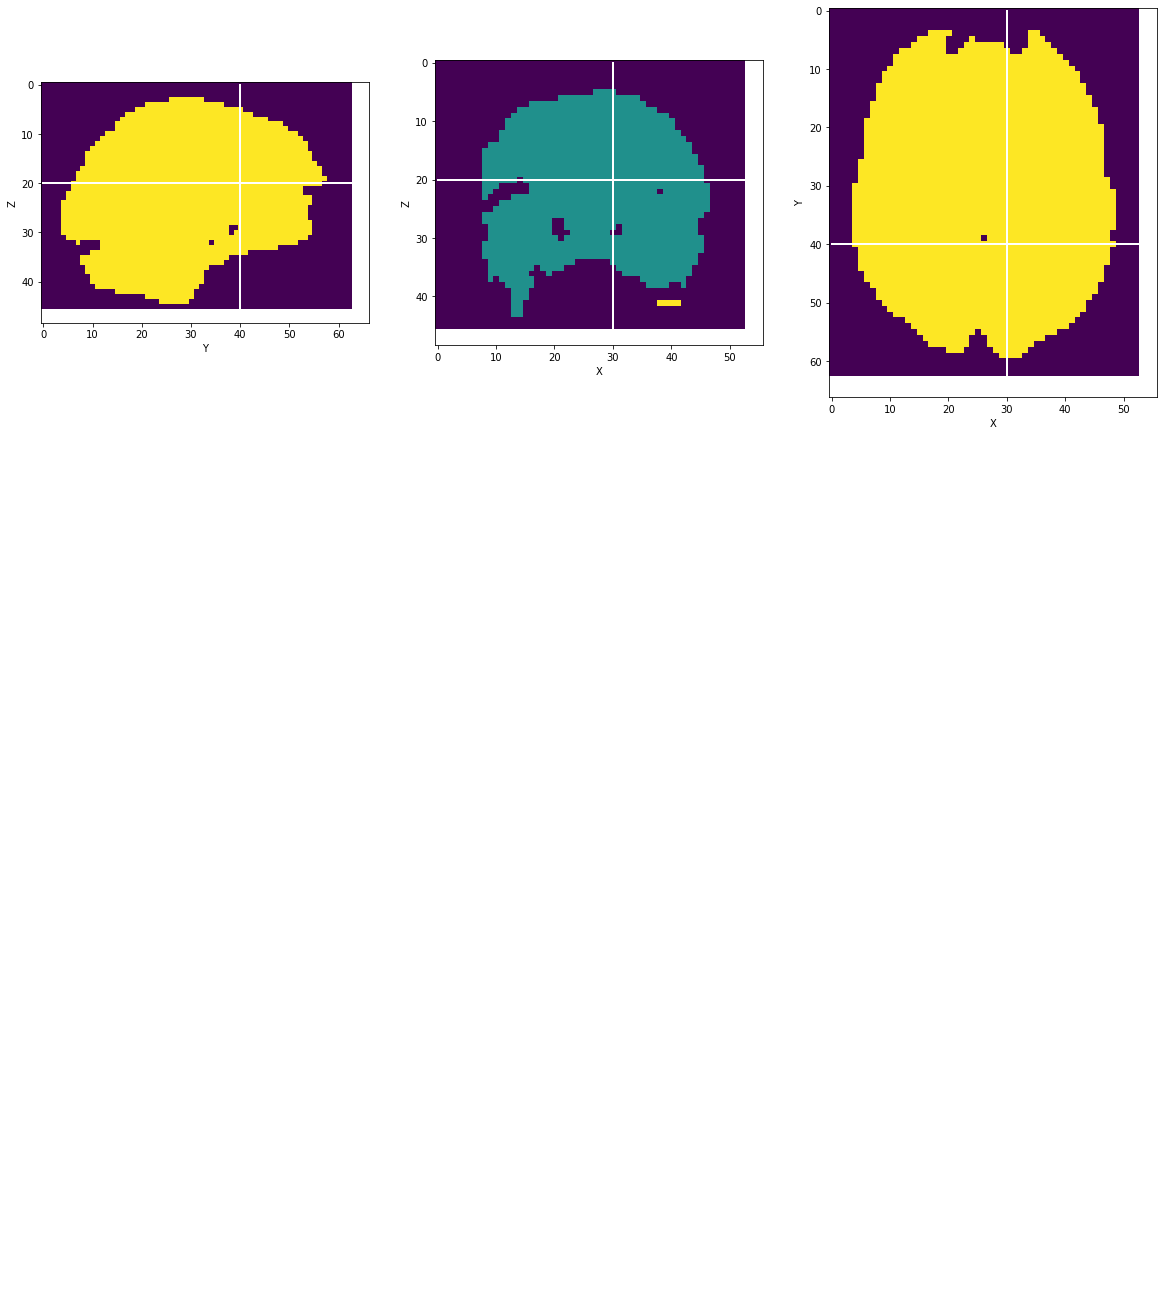

Num X clusters: 2
Num Y clusters: 3
Num Z clusters: 2
sizesX: [      0.         6959701.52392067]
sizesY: [      0.         4594509.20433938   14550.97234701]
sizesZ: [      0.         7917236.68445444]


In [27]:
def show_clusters_with_crosshairs(data, x, y, z, t, beta = False, threshold = 0.5):
    # if beta is True, search for interesting regions (max)
    if beta:
        shape = data.shape
    else:
        shape = data.get_fdata().shape
    xLength = shape[0]
    yLength = shape[1]
    zLength = shape[2]
    
    xIndex = x
    yIndex = y
    zIndex = z
    timeSlice = t
    
    plt.figure(figsize=(20,20))
    
    #X
    plt.subplot(1,3,1, xlabel='Y', ylabel='Z')  
    if beta:
        imgX = data[xIndex,:,:,timeSlice]
    else:
        imgX = data.get_fdata()[xIndex,:,:,timeSlice]
    rotated_imgX = ndimage.rotate(imgX, 90)
    maxX = np.max(rotated_imgX) # TODO: may work
    thresholded_rotated_imgX = rotated_imgX[rotated_imgX < threshold*maxX] = 0
    labeled_imgX, num_labelsX = ndimage.label(rotated_imgX)
    sizesX = ndimage.sum(rotated_imgX, labeled_imgX, range(num_labelsX + 1))
#     sliceX_x, sliceX_y = ndimage.find_objects(labeled_imgX==0)[0]
    Xlabels = np.unique(labeled_imgX)
    plt.imshow(labeled_imgX)
    plt.plot([0,yLength],[zIndex,zIndex],'w-', linestyle = "-", lw=2)
    plt.plot([yIndex,yIndex],[0,zLength],'w-', linestyle = "-", lw=2)
    plt.text(10, 245, 'x={}'.format(x), fontsize=12, color='white')
    
    #Y
    plt.subplot(1,3,2, xlabel='X', ylabel='Z')
    if beta:
        imgY = data[:,yIndex,:,timeSlice]
    else:
        imgY = data.get_fdata()[:,yIndex,:,timeSlice]
    rotated_imgY = ndimage.rotate(imgY, 90)
    maxY = np.max(rotated_imgY) # TODO: may work
    thresholded_rotated_imgY = rotated_imgY[rotated_imgY < threshold*maxY] = 0
    labeled_imgY, num_labelsY = ndimage.label(rotated_imgY)
    sizesY = ndimage.sum(rotated_imgY, labeled_imgY, range(num_labelsY + 1))
#     sliceY_x, sliceY_y = ndimage.find_objects(labeled_imgY==1)[0]
    Ylabels = np.unique(labeled_imgY)
    plt.imshow(labeled_imgY)
    plt.plot([0,xLength],[zIndex,zIndex],'w-', linestyle = "-", lw=2)
    plt.plot([xIndex,xIndex],[0,zLength],'w-', linestyle = "-", lw=2)
    plt.text(10, 175, 'y={}'.format(y), fontsize=12, color='white')
    
    #Z
    plt.subplot(1,3,3, xlabel='X', ylabel='Y')
    if beta:
        imgZ = data[:,:,zIndex,timeSlice]
    else:
        imgZ = data.get_fdata()[:,:,zIndex,timeSlice]
    rotated_imgZ = ndimage.rotate(imgZ, 90)
    maxZ = np.max(rotated_imgZ) # TODO: may work
    thresholded_rotated_imgZ = rotated_imgZ[rotated_imgZ < threshold*maxZ] = 0
    labeled_imgZ, num_labelsZ = ndimage.label(rotated_imgZ)
    sizesZ = ndimage.sum(rotated_imgZ, labeled_imgZ, range(num_labelsZ + 1))
#     sliceZ_x, sliceZ_y = ndimage.find_objects(labeled_imgZ==0)[0]
    Zlabels = np.unique(labeled_imgZ)
    plt.imshow(labeled_imgZ)
    plt.plot([0,xLength],[yIndex,yIndex],'w-', linestyle = "-", lw=2)
    plt.plot([xIndex,xIndex],[0,yLength],'w-', linestyle = "-", lw=2)
    plt.text(10, 175, 'z={}'.format(z), fontsize=12, color='white')
    
    plt.show()
    
    print("Num X clusters: " + str(len(Xlabels)))
    print("Num Y clusters: " + str(len(Ylabels)))
    print("Num Z clusters: " + str(len(Zlabels)))
    print("sizesX: " + str(sizesX))
    print("sizesY: " + str(sizesY))
    print("sizesZ: " + str(sizesZ))
#     print("X slices (0): " + "x:" + str(sliceX_x) + " y:" +  str(sliceX_y))
#     print("Y slices (1): " + "x:" + str(sliceY_x) + " y:" +  str(sliceY_y))
#     print("Z slices (0): " + "x:" + str(sliceZ_x) + " y:" +  str(sliceZ_y))
    
    #return 10,2,40
    
show_clusters_with_crosshairs(data, 30, 40, 20, 5)

In [28]:
xStart,yStart,zStart,tStart = find_most_active_regions(beta_map_motor_vs_cog)

@interact(x=(0,52), y=(0,62), z=(0,45), t=(0,21))
def interact_with_voxels(x=xStart, y=yStart, z=zStart, t=tStart):
#     xCoord,yCoord,zCoord = 
    show_clusters_with_crosshairs(beta_map_motor_vs_cog, x, y, z, t, True, 0.1)
#     print("Top X cluster coordinate: " + str(xCoord))
#     print("Top Y cluster coordinate: " + str(yCoord))
#     print("Top Z cluster coordinate: " + str(zCoord))

(53, 63, 46, 22)


interactive(children=(IntSlider(value=28, description='x', max=52), IntSlider(value=24, description='y', max=6…

## NEXT LAB STUFF

### Reusable code for seperate module:

In [99]:
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits import mplot3d
import scipy.misc
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter

class GLM_3D_Utils:
    
    @staticmethod
    def get_orig_data():
        return nib.load('preprocessed_fMRI_bold.nii.gz')
    
    @staticmethod
    def get_orig_mask():
        return nib.load('./sub-S01_mask.nii.gz')
    
    @staticmethod
    def get_localizer_design_matrix():
        design_matrix_localizer = DesignMatrixUtils.create_design_matrix(events, labels)

        funcs = [
            lambda dm : DesignMatrixUtils.convolve_hrf(dm, 2),
            lambda dm : DesignMatrixUtils.add_intercept(dm),
            lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 2),
            lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 3),
            lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 2, flipped = True),
            lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 3, flipped = True),  
            lambda dm : DesignMatrixUtils.add_cosine(dm, 1, 1),
            lambda dm : DesignMatrixUtils.add_cosine(dm, 2, 1),    
            lambda dm : DesignMatrixUtils.add_cosine(dm, 3, 1),        
        ]

        design_matrix_localizer_full = DesignMatrixUtils.add_many(design_matrix_localizer, funcs)
        return design_matrix_localizer_full


        
    
    @staticmethod
    def estimate_beta(X, Y):
        return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)
    
    @staticmethod
    def compute_beta_map(data, X):
        n_regressors = X.shape[1]
        beta_map = np.zeros((data.shape[0],data.shape[1],data.shape[2],n_regressors)) 
        
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                for k in range (data.shape[2]):
                    Y = data.get_fdata()[i,j,k,:]
                    bs = estimate_beta(X, Y)
                    beta_map[i,j,k,:] = bs
        return beta_map
    
#     @staticmethod
#     def compute_contrast(beta_map, contrast):    
#         b = np.squeeze(beta_map)
#         c = np.array(contrast).T
#         cs = np.dot(b,c)   
#         return cs
    
    @staticmethod
    def show_contrast(beta_map, contrast, axis='x', pos=0): 
        cs = compute_contrast(beta_map, contrast).squeeze().T
        plt.figure(figsize=(40,2))
        
        if (axis=='x' or axis=='X'):
            imgX = cs[pos,:,:].squeeze()
            plt.imshow(ndimage.rotate(imgX, 90), cmap='gray')
        if (axis=='y' or axis=='Y'):
            imgY = cs[:,pos,:].squeeze()
            plt.imshow(ndimage.rotate(imgY, 90), cmap='gray')
        if (axis=='z' or axis=='Z'):
            imgZ = cs[:,:,pos].squeeze()
            plt.imshow(ndimage.rotate(imgZ, 90), cmap='gray')
        
    @staticmethod
    def show_contrast_with_threshold(beta_map, contrast, axis='x', pos=0, threshold=0.5):
        cs = compute_contrast(beta_map, contrast).squeeze().T
        maximum = cs.max()
        cs[cs < maximum*threshold] = 0
        plt.figure(figsize=(40,2))
        
        if (axis=='x' or axis=='X'):
            imgX = cs[pos,:,:].squeeze()
            plt.imshow(ndimage.rotate(imgX, 90), cmap='gray')
        if (axis=='y' or axis=='Y'):
            imgY = cs[:,pos,:].squeeze()
            plt.imshow(ndimage.rotate(imgY, 90), cmap='gray')
        if (axis=='z' or axis=='Z'):
            imgZ = cs[:,:,pos].squeeze()
            plt.imshow(ndimage.rotate(imgZ, 90), cmap='gray')
        
        return cs
    
    # 3D Convolution to merge nearby clusters
    @staticmethod
    def smooth(data, sigma = 1): 
        #for i in range(data.shape[2]):
        #    data[:,:,i] = gaussian_filter(data[:,:,i],sigma=[1,1])
        #return
        return gaussian_filter(data, sigma)
    
    @staticmethod
    def ShowSlicesAcrossAxis(data, axis, numberOfSlices, steps):
        if axis == 'x':
            plt.figure(figsize=(30, 30))
            for i in range(numberOfSlices):
                if i*steps >= data.shape[0]:
                    break
                plt.subplot(10,5,i+1)
                plt.text(5,250,'x = %d'%(i*steps),color='white')
                plt.imshow(data[i*steps,:,:])
            plt.show()
        if axis == 'y':
            plt.figure(figsize=(30, 30))
            for i in range(numberOfSlices):
                if i*steps >= data.shape[1]:
                    break
                plt.subplot(10,5,i+1)
                plt.text(5,190,'y = %d'%(i*steps),color='white')
                plt.imshow(data[:,i*steps,:])
            plt.show()
        if axis == 'z':
            plt.figure(figsize=(30, 30))
            for i in range(numberOfSlices):
                if i*steps >= data.shape[2]:
                    break
                plt.subplot(10,5,i+1)
                plt.text(5,190,'z = %d'%(i*steps),color='white')
                plt.imshow(data[:,:,i*steps])
            plt.show()
            
    @staticmethod
    def visualize_contrast(beta_map, contrast, mask, axis, numSlices, steps):
        c = compute_contrast(beta_map, contrast)
        masked_contrast = np.multiply(c, mask)
        masked_contrast[masked_contrast == 0] = np.NINF

        ShowSlicesAcrossAxis(masked_contrast, axis, numSlices, steps)
        
    @staticmethod
    def visualize_contrast_with_threshold(beta_map, contrast, mask, axis, numSlices, steps, threshold):
        c = compute_contrast(beta_map, contrast)

        masked_contrast = np.multiply(c, mask)
        masked_contrast[masked_contrast == 0] = np.NINF

        maximum = masked_contrast.max()
        masked_contrast[masked_contrast <= threshold*maximum] = 1
        masked_contrast[mask == 0] = np.NINF
        #Everywhere that mask is 1, c will be set to 0
        c[mask] = 0

        ShowSlicesAcrossAxis(masked_contrast, axis, numSlices, steps)
        
    #==================================================================================
    #==================================================================================
    #==================================================================================
    @staticmethod
    def get_contrast_thresholded(beta_map, contrast_vector, mask, threshold):
        c = compute_contrast(beta_map, contrast_vector)
        
        print("c's shape:")
        print(c.shape)
        print("mask's shape:")
        print(mask.shape)
        masked_contrast = np.multiply(c, mask)
        masked_contrast[masked_contrast == 0] = np.NINF

        maximum = masked_contrast.max()

        masked_contrast[masked_contrast <= threshold*maximum] = 1
        masked_contrast[mask == 0] = np.NINF
        masked_contrast[masked_contrast == 1] = 0

        return masked_contrast
    
    @staticmethod
    def show_voxel_with_crosshairs(data, x, y, z, t, beta = False):
        # if beta is True, search for interesting regions (max)
        if beta:
            shape = data.shape
        else:
            shape = data.get_fdata().shape
        xLength = shape[0]
        yLength = shape[1]
        zLength = shape[2]

        xIndex = x
        yIndex = y
        zIndex = z
        timeSlice = t

        plt.figure(figsize=(10,10))

        plt.subplot(1,3,1, xlabel='Y', ylabel='Z')  
        if beta:
            imgX = data[xIndex,:,:,timeSlice]
        else:
            imgX = data.get_fdata()[xIndex,:,:,timeSlice]
        rotated_imgX = ndimage.rotate(imgX, 90)
        plt.imshow(rotated_imgX, 'gray', interpolation='none')
        plt.plot([0,yLength],[zIndex,zIndex],'w-', linestyle = "-", lw=2)
        plt.plot([yIndex,yIndex],[0,zLength],'w-', linestyle = "-", lw=2)
        plt.text(10, 245, 'x={}'.format(x), fontsize=12, color='white')

        plt.subplot(1,3,2, xlabel='X', ylabel='Z')
        if beta:
            imgY = data[:,yIndex,:,timeSlice]
        else:
            imgY = data.get_fdata()[:,yIndex,:,timeSlice]
        rotated_imgY = ndimage.rotate(imgY, 90)
        plt.imshow(rotated_imgY, 'gray', interpolation='none')
        plt.plot([0,xLength],[zIndex,zIndex],'w-', linestyle = "-", lw=2)
        plt.plot([xIndex,xIndex],[0,zLength],'w-', linestyle = "-", lw=2)
        plt.text(10, 175, 'y={}'.format(y), fontsize=12, color='white')

        plt.subplot(1,3,3, xlabel='X', ylabel='Y')
        if beta:
            imgZ = data[:,:,zIndex,timeSlice]
        else:
            imgZ = data.get_fdata()[:,:,zIndex,timeSlice]
        rotated_imgZ = ndimage.rotate(imgZ, 90)
        plt.imshow(rotated_imgZ, 'gray', interpolation='none')
        plt.plot([0,xLength],[yIndex,yIndex],'w-', linestyle = "-", lw=2)
        plt.plot([xIndex,xIndex],[0,yLength],'w-', linestyle = "-", lw=2)
        plt.text(10, 175, 'z={}'.format(z), fontsize=12, color='white')

        plt.show()
        
#     @interact(x=(0,52), y=(0,62), z=(0,45), t=(0,127))
#     def interact_with_voxels(x=1, y=1, z=1, t=1):
#         show_voxel_with_crosshairs(data, x, y, z, t, beta=False)

    @staticmethod
    def sum_image_values(img):
        assert(len(img.shape)==2)
        return np.sum(img)

    ## Find maximum slices in beta map. Remember shape is: (53, 63, 46, 22)
    @staticmethod
    def find_most_active_regions(beta_map):
        xLength = beta_map.shape[0]
        yLength = beta_map.shape[1]
        zLength = beta_map.shape[2]
        tLength = beta_map.shape[3]

        # Find max X image
        maxX = float("-inf")
        xVal = -1
        tXVal = -1
        for x in range(xLength):
            for t in range(tLength):
                betaImg = beta_map[x,:,:,t]
                imgSum = sum_image_values(betaImg)
                if (imgSum > maxX):
                    maxX = imgSum
                    xVal = x
                    tXVal = t

        # Find max Y image
        maxY = float("-inf")
        yVal = -1
        tYVal = -1
        for y in range(yLength):
            for t in range(tLength):
                betaImg = beta_map[:,y,:,t]
                imgSum = sum_image_values(betaImg)
                if (imgSum > maxY):
                    maxY = imgSum
                    yVal = y
                    tYVal = t

        # Find max Z image
        maxZ = float("-inf")
        zVal = -1
        tZVal = -1
        for z in range(zLength):
            for t in range(tLength):
                betaImg = beta_map[:,:,z,t]
                imgSum = sum_image_values(betaImg)
                if (imgSum > maxZ):
                    maxZ = imgSum
                    zVal = z
                    tZVal = t

        # Use t that maximizes the sum of all three axis slices
        maxT = float("-inf")
        tVal = -1
        for t in [tXVal, tYVal, tZVal]:
            xSum = sum_image_values(beta_map[xVal,:,:,t])
            ySum = sum_image_values(beta_map[:,yVal,:,t])
            zSum = sum_image_values(beta_map[:,:,zVal,t])
            tSum = xSum + ySum + zSum
            if (tSum > maxT):
                tVal = t

        print(beta_map.shape)

        return xVal,yVal,zVal,tVal
        
    @staticmethod
    def contrast_vector_from_name(design_matrix, pos_name, neg_name):
        contrast_vector = np.zeros(design_matrix.shape[1])
        cols = design_matrix.columns

        for i,col in enumerate(cols):
            if (pos_name in col):
                contrast_vector[i] = 1
            elif (neg_name in col):
                contrast_vector[i] = -1

        # Hardcodings
        if (pos_name == "visual"):
            contrast_vector[0] = 1 # horizontal checkerboard
            contrast_vector[1] = 1 # vertical checkerboard
        if (neg_name == "visual"):
            contrast_vector[0] = -1 # horizontal checkerboard
            contrast_vector[1] = -1 # vertical checkerboard
        if ("number" in pos_name):
            contrast_vector[6] = 1 # subtraction_auditory 
            contrast_vector[7] = 1 # subtraction_visual
        if ("number" in neg_name):
            contrast_vector[6] = -1 # subtraction_auditory 
            contrast_vector[7] = -1 # subtraction_visual
        if ("word" in pos_name):
            contrast_vector[8] = 1 # sentence_visual
            contrast_vector[9] = 1 # sentence_auditory
        if ("word" in neg_name):
            contrast_vector[8] = -1 # sentence_visual
            contrast_vector[9] = -1 # sentence_auditory
        if ("cog" in pos_name):
            contrast_vector[6] = 1 # subtraction_auditory 
            contrast_vector[7] = 1 # subtraction_visual
            contrast_vector[8] = 1 # sentence_visual
            contrast_vector[9] = 1 # sentence_auditory
        if ("cog" in neg_name):
            contrast_vector[6] = -1 # subtraction_auditory 
            contrast_vector[7] = -1 # subtraction_visual
            contrast_vector[8] = -1 # sentence_visual
            contrast_vector[9] = -1 # sentence_auditory

        # make the numbers add up to 0
        # count number of positives and negs, divide 1 by those numbers
        num_positives = 0
        num_negatives = 0

        for i,num in enumerate(contrast_vector):
            if (num == 1):
                num_positives = num_positives + 1
            elif (num == -1):
                num_negatives = num_negatives + 1

        pos_value = float(1.0/num_positives)
        neg_value = float(1.0/num_negatives)

        for i,num in enumerate(contrast_vector):
            if (num == 1):
                contrast_vector[i] = pos_value
            elif (num == -1):
                contrast_vector[i] = neg_value

        return contrast_vector

    
    @staticmethod
    def get_most_active_slice(data, axis):
        x,y,z = data.shape
        copy = data.copy()
        copy[copy == np.NINF] = 0

        maximum = 0
        slice_index = 0

        if axis == 'x':
            for i in range(x):
                summ = copy[i,:,:].sum()
                if summ > maximum:
                    slice_index = i
                    maximum = summ
            return slice_index

        if axis == 'y':
            for i in range(y):
                summ = copy[:,i,:].sum()
                if summ > maximum:
                    slice_index = i
                    maximum = summ
            return slice_index

        if axis == 'z':
            for i in range(z):
                summ = copy[:,:,i].sum()
                if summ > maximum:
                    slice_index = i
                    maximum = summ
            return slice_index
        
    @staticmethod
    def ShowLocationWithMask(data, mask, x, y, z):
        x_size, y_size, z_size = data.shape

        fontsize = 50

        #x_abs, y_abs, z_abs = x+int(x_size/2), y+int(y_size/2), z+int(z_size/2)
        x_abs, y_abs, z_abs = x,y,z

        if x_abs >= x_size or y_abs >= y_size or z_abs >=z_size:
            print("Invalid location")
            return
        if x_abs < 0 or y_abs < 0 or z_abs < 0:
            print("Invalid location")
            return

        data_arr = data
        xslice = np.rot90(data_arr[x_abs,:,:],1)
        yslice = np.rot90(data_arr[:,y_abs,:],1)
        zslice = np.rot90(data_arr[:,:,-z_abs],1)

        mask_arr = mask
        xslice_mask = np.rot90(mask_arr[x_abs,:,:],1)
        yslice_mask = np.rot90(mask_arr[:,y_abs,:],1)
        zslice_mask = np.rot90(mask_arr[:,:,-z_abs],1)

        fig,ax = plt.subplots(ncols=3,sharey=True,gridspec_kw={'width_ratios': [1,y_size/x_size,1]}, figsize=(40,30))

        ax[1].imshow(xslice, interpolation='none')
        #ax[1].imshow(xslice_mask, 'jet', alpha=0.5, interpolation='none')
        ax[1].text(5,y_size-5,'x = %d'%(x),color='black',fontsize=fontsize)
        ax[1].axis('off')
        ax[1].axhline(z_abs,color='white',linewidth=2)
        ax[1].axvline(y_abs,color='white',linewidth=2)

        ax[2].imshow(zslice, interpolation='none')
        #ax[2].imshow(zslice_mask, 'jet', alpha=0.5, interpolation='none')
        ax[2].text(5,y_size-5,'z = %d'%(z),color='black',fontsize=fontsize)
        ax[2].text(5,5,'L',color='black',fontsize=fontsize)
        ax[2].text(x_size-5,5,'R',color='black',fontsize=fontsize)
        ax[2].axis('off')
        ax[2].axhline(y_abs,color='white',linewidth=2)
        ax[2].axvline(x_abs,color='white',linewidth=2)

        ax[0].imshow(yslice, interpolation='none')
        #ax[0].imshow(yslice_mask, 'jet', alpha=0.5, interpolation='none')
        ax[0].text(5,y_size-5,'y = %d'%(y),color='black',fontsize=fontsize)
        ax[0].text(5,5,'L',color='black',fontsize=fontsize)
        ax[0].text(x_size-5,5,'R',color='black',fontsize=fontsize)
        ax[0].axis('off')
        ax[0].axhline(z_abs,color='white',linewidth=2)
        ax[0].axvline(x_abs,color='white',linewidth=2)

        fig.subplots_adjust(wspace=0, hspace=0)
        plt.show()
        
    @staticmethod
    def show_clusters_with_crosshairs(data, x, y, z, t, beta = False, threshold = 0.5):
        # if beta is True, search for interesting regions (max)
        if beta:
            shape = data.shape
        else:
            shape = data.get_fdata().shape
        xLength = shape[0]
        yLength = shape[1]
        zLength = shape[2]

        xIndex = x
        yIndex = y
        zIndex = z
        timeSlice = t

        plt.figure(figsize=(20,20))

        #X
        plt.subplot(1,3,1, xlabel='Y', ylabel='Z')  
        if beta:
            imgX = data[xIndex,:,:,timeSlice]
        else:
            imgX = data.get_fdata()[xIndex,:,:,timeSlice]
        rotated_imgX = ndimage.rotate(imgX, 90)
        maxX = np.max(rotated_imgX) # TODO: may work
        thresholded_rotated_imgX = rotated_imgX[rotated_imgX < threshold*maxX] = 0
        labeled_imgX, num_labelsX = ndimage.label(rotated_imgX)
        sizesX = ndimage.sum(rotated_imgX, labeled_imgX, range(num_labelsX + 1))
    #     sliceX_x, sliceX_y = ndimage.find_objects(labeled_imgX==0)[0]
        Xlabels = np.unique(labeled_imgX)
        plt.imshow(labeled_imgX)
        plt.plot([0,yLength],[zIndex,zIndex],'w-', linestyle = "-", lw=2)
        plt.plot([yIndex,yIndex],[0,zLength],'w-', linestyle = "-", lw=2)
        plt.text(10, 245, 'x={}'.format(x), fontsize=12, color='white')

        #Y
        plt.subplot(1,3,2, xlabel='X', ylabel='Z')
        if beta:
            imgY = data[:,yIndex,:,timeSlice]
        else:
            imgY = data.get_fdata()[:,yIndex,:,timeSlice]
        rotated_imgY = ndimage.rotate(imgY, 90)
        maxY = np.max(rotated_imgY) # TODO: may work
        thresholded_rotated_imgY = rotated_imgY[rotated_imgY < threshold*maxY] = 0
        labeled_imgY, num_labelsY = ndimage.label(rotated_imgY)
        sizesY = ndimage.sum(rotated_imgY, labeled_imgY, range(num_labelsY + 1))
    #     sliceY_x, sliceY_y = ndimage.find_objects(labeled_imgY==1)[0]
        Ylabels = np.unique(labeled_imgY)
        plt.imshow(labeled_imgY)
        plt.plot([0,xLength],[zIndex,zIndex],'w-', linestyle = "-", lw=2)
        plt.plot([xIndex,xIndex],[0,zLength],'w-', linestyle = "-", lw=2)
        plt.text(10, 175, 'y={}'.format(y), fontsize=12, color='white')

        #Z
        plt.subplot(1,3,3, xlabel='X', ylabel='Y')
        if beta:
            imgZ = data[:,:,zIndex,timeSlice]
        else:
            imgZ = data.get_fdata()[:,:,zIndex,timeSlice]
        rotated_imgZ = ndimage.rotate(imgZ, 90)
        maxZ = np.max(rotated_imgZ) # TODO: may work
        thresholded_rotated_imgZ = rotated_imgZ[rotated_imgZ < threshold*maxZ] = 0
        labeled_imgZ, num_labelsZ = ndimage.label(rotated_imgZ)
        sizesZ = ndimage.sum(rotated_imgZ, labeled_imgZ, range(num_labelsZ + 1))
    #     sliceZ_x, sliceZ_y = ndimage.find_objects(labeled_imgZ==0)[0]
        Zlabels = np.unique(labeled_imgZ)
        plt.imshow(labeled_imgZ)
        plt.plot([0,xLength],[yIndex,yIndex],'w-', linestyle = "-", lw=2)
        plt.plot([xIndex,xIndex],[0,yLength],'w-', linestyle = "-", lw=2)
        plt.text(10, 175, 'z={}'.format(z), fontsize=12, color='white')

        plt.show()

        print("Num X clusters: " + str(len(Xlabels)))
        print("Num Y clusters: " + str(len(Ylabels)))
        print("Num Z clusters: " + str(len(Zlabels)))
        print("sizesX: " + str(sizesX))
        print("sizesY: " + str(sizesY))
        print("sizesZ: " + str(sizesZ))
    #     print("X slices (0): " + "x:" + str(sliceX_x) + " y:" +  str(sliceX_y))
    #     print("Y slices (1): " + "x:" + str(sliceY_x) + " y:" +  str(sliceY_y))
    #     print("Z slices (0): " + "x:" + str(sliceZ_x) + " y:" +  str(sliceZ_y))

        #return 10,2,40
        
    @staticmethod
    def find_clusters(data, axis):
        assert(axis=='x' or axis=='y' or axis=='z')
        labeled_img, num_labels = ndimage.label(data)
        print('labeled_img:')
        print(labeled_img)
        print('num_labels:')
        print(num_labels)
        
    
    @staticmethod
    def exploreContrast(data, design_matrix, contrast_keywords, contrast_threshold, mask):
        print('Computing Beta Map...')
        beta_map = compute_beta_map(data, design_matrix)

        print('Computing Contrast for %s vs. %s'%(contrast_keywords[0],contrast_keywords[1]))
        contrast_vector = get_contrast_vector(contrast_keywords)

        contrast = get_contrast_thresholded(beta_map, contrast_vector, mask, contrast_threshold)


        # --- Clustering code started from Thurs ---

        #Making a deep copy of the contrast so I dont overwrite it (janky)
        contrast_cluster = contrast.copy()

        #Setting the -inf mask that displays nicely to 0 for ndimage.cluster
        contrast_cluster[contrast_cluster == np.NINF] = 0

        #Running ndimage on contrast copy
        labels, num_features = scipy.ndimage.label(contrast_cluster)

        #Debug output
        print(num_features)
        print(labels)

        #Masking out everything that isn't in cluter 1 in the original contrast (will affect the visualization belpow)
        contrast[labels!=1] = np.NINF

        #-------------------------------------------

        x_lim, y_lim, z_lim = contrast.shape

        x_default = get_most_active_slice(contrast, 'x')
        y_default = get_most_active_slice(contrast, 'y')
        z_default = get_most_active_slice(contrast, 'z')

        interact_manual(ShowLocationWithMask,
                        data=fixed(contrast),
                        mask=fixed(mask),
                        x = widgets.IntSlider(min=0,max=x_lim,value=x_default), 
                        y = widgets.IntSlider(min=0,max=y_lim,value=y_default), 
                        z = widgets.IntSlider(min=0,max=z_lim,value=z_default)) 
        return
    
    @staticmethod
    def exploreContrast_with_betaMap_and_contrasts(beta_map, contrast_vector, contrast_threshold, mask):
        contrast = get_contrast_thresholded(beta_map, contrast_vector, mask, contrast_threshold)

        # --- Clustering code started from Thurs ---

        #Making a deep copy of the contrast so I dont overwrite it (janky)
        contrast_cluster = contrast.copy()

        #Setting the -inf mask that displays nicely to 0 for ndimage.cluster
        contrast_cluster[contrast_cluster == np.NINF] = 0

        #Running ndimage on contrast copy
        labels, num_features = scipy.ndimage.label(contrast_cluster)

        #Debug output
        print("Num features:")
        print(num_features)
        print("Labels:")
        print(labels)

        #Masking out everything that isn't in cluter 1 in the original contrast (will affect the visualization below)
        contrast[labels!=1] = np.NINF

        #-------------------------------------------

        x_lim, y_lim, z_lim = contrast.shape

        x_default = get_most_active_slice(contrast, 'x')
        y_default = get_most_active_slice(contrast, 'y')
        z_default = get_most_active_slice(contrast, 'z')

        interact_manual(ShowLocationWithMask,
                        data=fixed(contrast),
                        mask=fixed(mask),
                        x = widgets.IntSlider(min=0,max=x_lim,value=x_default), 
                        y = widgets.IntSlider(min=0,max=y_lim,value=y_default), 
                        z = widgets.IntSlider(min=0,max=z_lim,value=z_default)) 
        return


#----DesignMatrixUtils------------------------------------------------------------------------------------
class DesignMatrixUtils:
    pass

## Returns a design matrix: a pandas dataframe where each column is an event design vector
def create_design_matrix(events, labels, tr=2.4, duration=128): 
    df = pd.DataFrame(columns=labels)
    for i in range(len(labels)):
        line = compute_design_vector(events, i, duration, tr).astype('int')
        df[labels[i]] = line
    return df

DesignMatrixUtils.create_design_matrix = create_design_matrix

## Plots a design matrix. Each column (or row, depending on orientation) is a design vector
def plot(design_matrix, orientation = 'horizontal'):  
    values = design_matrix.values 
    labels = design_matrix.columns
    m = len(labels)
    if orientation == 'vertical':
        f, a = plt.subplots(ncols=m, figsize=(m*1.5, 10), sharey=True)
    elif orientation == 'horizontal':
        f, a = plt.subplots(nrows=m, figsize=(10, m), sharex=True)
    else:
        raise Exception("Invalid orientation") 
    times = range(values.shape[0])
    for i in range(0, m):        
        label = labels[i]
        
        if orientation == 'vertical':
            a[i].plot(values[:,i], times)
            a[i].set_title(label, fontsize=12, rotation=45)
        else:
            a[i].plot(times,values[:,i])
            a[i].set_title(label, fontsize=12)
    if orientation == 'vertical':
        plt.gca().invert_yaxis()
    plt.tight_layout()
    return

DesignMatrixUtils.plot = plot

## Returns a subset of a design matrix containing only events with "[task]" in their name
def select_tasks_with_name(design_matrix, task):
    selected_tasks = [col for col in design_matrix.columns if task in col]
    return design_matrix[selected_tasks]

DesignMatrixUtils.select_tasks_with_name = select_tasks_with_name

## Plots a design matrix using a heatmap
def heatmap(design_matrix):     
    sns.heatmap(design_matrix)
    return

DesignMatrixUtils.heatmap = heatmap

## Adds an intercept column to a design matrix
def add_intercept(design_matrix):  
    design_matrix_copy = design_matrix.copy()
    n_rows, n_cols = design_matrix.shape
    design_matrix_copy['intercept'] = np.ones(n_rows)
    return design_matrix_copy

DesignMatrixUtils.add_intercept = add_intercept

## Adds polynomial columns to a design matrix
def add_poly(design_matrix, degrees=2, flipped=False):
    frames = design_matrix.shape[0]
    time = np.linspace(-1, 1, frames)
    for i in range(degrees+1):
        key = '1-poly%d'%(i) if flipped else 'poly%d'%(i)
        design_matrix[key] = (time ** i) * (-1 if flipped else 1)
    return design_matrix

DesignMatrixUtils.add_poly = add_poly

## Adds a cosine column to a design matrix
def add_cosine(design_matrix, freq, amplitude, phase = 0):     
    duration = design_matrix.shape[0]
    time = np.linspace(0, 1, duration)
    w = amplitude * sin(2*pi*freq*time + pi*phase)
    copy = design_matrix.copy()
    copy['cos'+str(freq)] = w
    return copy
    ### END SOLUTION
DesignMatrixUtils.add_cosine = add_cosine

## Convolves each column in a design matrix with the hrf function
def convolve_hrf(design_matrix, tr=2.4):     
    design_matrix_copy = design_matrix.copy() # Avoid modifying the original dataframe
    hrf = glover_hrf(tr, oversampling=1) 
    labels = design_matrix.columns
    for label in labels:
        design_matrix_copy[label] = np.convolve(design_matrix_copy[label].to_numpy(), hrf, mode='same') 
    return design_matrix_copy

DesignMatrixUtils.convolve_hrf = convolve_hrf

## Returns a design matrix with all functions in [funcs] applied to it
def add_many(design_matrix, funcs = []):     
    design_matrix_copy = design_matrix.copy() # Avoid modifying the original dataframe
    for func in funcs:
        design_matrix_copy = func(design_matrix_copy)
    return design_matrix_copy
    
DesignMatrixUtils.add_many = add_many


#----------------------------------------------------------------------------------------------


- 3D Convolution to merge nearby clusters (/)
- Find clusters 
- Find cluster centers
- Slider to explore clusters
- Offload reusable code into seperate module

## 3D Convolution to merge nearby clusters

In [96]:
data_copy = GLM_3D_Utils.get_orig_data().get_fdata()
data_convolved = GLM_3D_Utils.smooth(data_copy)

#print(data_convolved)

## Find clusters

In [100]:
data = GLM_3D_Utils.get_orig_data()
mask = GLM_3D_Utils.get_orig_mask().get_fdata()
design_matrix = GLM_3D_Utils.get_localizer_design_matrix()
contrast_vector = GLM_3D_Utils.contrast_vector_from_name(design_matrix, "visual", "aud")

beta_map_visual_vs_aud = GLM_3D_Utils.compute_beta_map(data, design_matrix.values)

In [101]:
# z = GLM_3D_Utils.show_contrast_with_threshold(beta_map_visual_vs_aud, contrast_vector, axis='y', pos=10, threshold=.1)
xStart,yStart,zStart,tStart = find_most_active_regions(beta_map_visual_vs_aud)

(53, 63, 46, 22)


In [102]:
threshold = 0.1
brain_processed = GLM_3D_Utils.get_contrast_thresholded(beta_map_visual_vs_aud, contrast_vector, mask, threshold)

# @interact(x=(0,52), y=(0,62), z=(0,45), t=(0,21))
# def interact_with_voxels(x=xStart, y=yStart, z=zStart, t=tStart):
#     show_clusters_with_crosshairs(beta_map_motor_vs_cog, x, y, z, t, True, threshold)

GLM_3D_Utils.find_clusters(brain_processed, 'x')

c's shape:
(1, 46, 63, 53)
mask's shape:
(53, 63, 46)


ValueError: operands could not be broadcast together with shapes (1,46,63,53) (53,63,46) 

## Find cluster centers

## Slider to explore clusters

## Offload reusable code into seperate module (above)